In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!cd /content/drive/MyDrive/nlp/ner

Mounted at /content/drive


# Data

In [ ]:
import pandas as pd

In [ ]:
train = pd.read_csv("/content/drive/MyDrive/nlp/ner/train_data_ner.csv")
test = pd.read_csv("/content/drive/MyDrive/nlp/ner/test_data_ner.csv")
tiny = pd.read_csv("/content/drive/MyDrive/nlp/ner/tiny_test.csv")

In [ ]:
df = train.copy()
df["words"] = df['words'].apply(lambda x: str(x) + ' ')
sentences = df.groupby(by="sentence_id")["words"].sum().reset_index()
sentences["words"] = sentences["words"].str.replace(" ,", ",").replace(" .", ".")
sentences

,sentence_id,words
0,0,Thousands of demonstrators have marched throug...
1,2,Helicopter gunships Saturday pounded militant ...
2,3,They left after a tense hour-long standoff wit...
3,4,U.N. relief coordinator Jan Egeland said Sunda...
4,5,Mr. Egeland said the latest figures show 1.8 m...
...,...,...
38361,47951,He called it a vital tool for national securit...
38362,47952,Iran 's elite security forces are warning oppo...
38363,47954,Opposition leader Mir Hossein Mousavi has said...
38364,47955,"On Thursday, Iranian state media published a m..."


In [ ]:

train

,sentence_id,words,tags
0,0,Thousands,O
1,0,of,O
2,0,demonstrators,O
3,0,have,O
4,0,marched,O
...,...,...,...
839144,47957,officials,O
839145,47957,within,O
839146,47957,the,O
839147,47957,government,O


# Model #1

In [ ]:
# Pretrained distil bert

from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline

tokenizer = AutoTokenizer.from_pretrained("dslim/distilbert-NER")
model = AutoModelForTokenClassification.from_pretrained("dslim/distilbert-NER")

nlp = pipeline("ner", model=model, tokenizer=tokenizer)
example = "My name is Wolfgang and I live in Berlin."

ner_results = nlp(example)
print(ner_results)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/669k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/926 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/261M [00:00<?, ?B/s]

[{'entity': 'B-PER', 'score': 0.99230945, 'index': 4, 'word': 'Wolfgang', 'start': 11, 'end': 19}, {'entity': 'B-LOC', 'score': 0.99754506, 'index': 9, 'word': 'Berlin', 'start': 34, 'end': 40}]


In [ ]:
results = pd.DataFrame(ner_results)
results = results[['word', 'entity']]
results.columns = ['words', 'tags']
results["sentence_id"] = 0
results

#falta renaming de las tags
#finetuning

,words,tags,sentence_id
0,Wolfgang,B-PER,0
1,Berlin,B-LOC,0


# Transformer from scratch #2


In [ ]:
# Import necessary libraries
import torch
from transformers import BertTokenizer, BertForTokenClassification
from transformers import AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader

# Load the BERT tokenizer and model
NUM_LABELS = len(train["tags"].unique())
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForTokenClassification.from_pretrained("bert-base-uncased", num_labels=NUM_LABELS)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Get data in the correct structure
def tokenize_words(df):
    sentences = df.groupby(by="sentence_id")["words"].apply(list)
    tags = df.groupby(by="sentence_id")["tags"].apply(list)

    tokens = []
    labels = []

    for word, label in zip(sentences, tags):
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)
        tokens.extend(tokenized_word)
        labels.extend([label] * n_subwords)

    return tokens, labels

tokens, labels = tokenize_words(train)

In [ ]:
# Tokenization
def tokenize_words(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)
        tokenized_sentence.extend(tokenized_word)
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels

# Assuming `sentences` and `labels` are lists containing sentences and their corresponding labels
tokenized_texts_and_labels = [tokenize_words(sent, labs) for sent, labs in zip(sentences, labels)]
tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]

# Convert tokenized text and labels to tensor format
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts], maxlen=MAX_LEN, dtype="long", value=0.0, truncating="post", padding="post")
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels], maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post", dtype="long", truncating="post")

# Create attention masks to ignore padded tokens
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]

# Split data into train and validation sets and wrap them in DataLoader for efficient batching

# Fine-tuning setup
optimizer = AdamW(model.parameters(), lr=3e-5, eps=1e-8)
total_steps = len(train_dataloader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training loop
for _ in range(EPOCHS):
    model.train()
    for batch in train_dataloader:
        b_input_ids, b_labels, b_masks = batch
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_masks, labels=b_labels)
        loss = outputs[0]
        loss.backward()
        optimizer.step()
        scheduler.step()
        model.zero_grad()
    # Validation loop can be added here

model.save_pretrained("./ner_model")

# New approach #3

In [ ]:
#  Install Python libraries using pip inside Colab
!pip install accelerate -U
!pip install -U transformers
!pip install evaluate
#!pip install datasets tokenizers seqeval -q
#!pip install tensorflow_probability -U
!pip install seqeval -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 4.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [ ]:
# Import tokenizer from a pretrained BERT

from transformers import AutoTokenizer

model_checkpoint = "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [ ]:
# tag dict to correlate labels and numbers
tag_dict = {'O': 0,}
i = 1
for name in ['geo', 'gpe', 'tim', 'org', 'per', 'art', 'nat', 'eve']:
    for prefix in ["B-", "I-"]:
        tag_dict[prefix + name] = i
        i += 1
tag_dict

{'O': 0,
 'B-geo': 1,
 'I-geo': 2,
 'B-gpe': 3,
 'I-gpe': 4,
 'B-tim': 5,
 'I-tim': 6,
 'B-org': 7,
 'I-org': 8,
 'B-per': 9,
 'I-per': 10,
 'B-art': 11,
 'I-art': 12,
 'B-nat': 13,
 'I-nat': 14,
 'B-eve': 15,
 'I-eve': 16}

In [ ]:
df = train.copy()
df["number_tag"] = df["tags"].replace(tag_dict)

In [ ]:
df['words'] = df['words'].astype(str)
sentences = df.groupby(by="sentence_id")["words"].apply(list)
print(sentences[0])

tags = df.groupby(by="sentence_id")["number_tag"].apply(list)
print(tags[0])

['Thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'London', 'to', 'protest', 'the', 'war', 'in', 'Iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'British', 'troops', 'from', 'that', 'country', '.']
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0]


In [ ]:
data = {}
data["words"] = sentences.tolist()
data["tags"] = tags.tolist()

In [ ]:
df = pd.DataFrame()
df["words"] = sentences
df["tags"] = tags
df = df.reset_index()
df

,sentence_id,words,tags
0,0,"[Thousands, of, demonstrators, have, marched, ...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, ..."
1,2,"[Helicopter, gunships, Saturday, pounded, mili...","[0, 0, 5, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 7, ..."
2,3,"[They, left, after, a, tense, hour-long, stand...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3,4,"[U.N., relief, coordinator, Jan, Egeland, said...","[1, 0, 0, 9, 10, 0, 5, 0, 1, 0, 3, 0, 3, 0, 0,..."
4,5,"[Mr., Egeland, said, the, latest, figures, sho...","[9, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
...,...,...,...
38361,47951,"[He, called, it, a, vital, tool, for, national...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
38362,47952,"[Iran, 's, elite, security, forces, are, warni...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
38363,47954,"[Opposition, leader, Mir, Hossein, Mousavi, ha...","[0, 0, 0, 9, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
38364,47955,"[On, Thursday, ,, Iranian, state, media, publi...","[0, 5, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 0, ..."


In [ ]:
# Convert DataFrame to a list of dictionaries
#data = df.to_dict(orient="records")

In [ ]:
# Test tokenizer
inputs = tokenizer(sentences[0], is_split_into_words=True)
inputs.tokens()

['[CLS]',
 'Thousands',
 'of',
 'demons',
 '##tra',
 '##tors',
 'have',
 'marched',
 'through',
 'London',
 'to',
 'protest',
 'the',
 'war',
 'in',
 'Iraq',
 'and',
 'demand',
 'the',
 'withdrawal',
 'of',
 'British',
 'troops',
 'from',
 'that',
 'country',
 '.',
 '[SEP]']

In [ ]:
inputs.word_ids()

[None,
 0,
 1,
 2,
 2,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 None]

In [ ]:
# Fix labels according to word_ids
def align_labels_with_tokens(labels, word_ids):
    new_labels = [] # correct labels

    # Initialize a variable to keep track of the current word's ID
    current_word = None

    for word_id in word_ids:
        if word_id != current_word: # Start of a new word/entity
            current_word = word_id

            # Assign -100 to labels for special tokens, else use the word's label
            label = -100 if word_id is None else labels[word_id]
            new_labels.append(label)
        elif word_id is None:
            # Handle special tokens by assigning them a label of -100
            new_labels.append(-100)
        else: # Token belongs to the same word/entity as the previous token
            label = labels[word_id]
            if label % 2 == 1: # If word split into different tokens: B -> I
                label += 1
            new_labels.append(label)
    return new_labels

In [ ]:
tags[0]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0]

In [ ]:
align_labels_with_tokens(tags[0], inputs.word_ids())

[-100,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 3,
 0,
 0,
 0,
 0,
 0,
 -100]

In [ ]:
def tokenize_and_align_labels(examples, save_wordid=False):
    tokenized_inputs = tokenizer(
        examples["words"], truncation=True, is_split_into_words=True
    )
    all_labels = examples["tags"]
    new_labels = []
    for i, labels in enumerate(all_labels):
        word_ids = tokenized_inputs.word_ids(i)
        new_labels.append(align_labels_with_tokens(labels, word_ids))

    tokenized_inputs["labels"] = new_labels
    if save_wordid:
        return tokenized_inputs, [tokenized_inputs.word_ids(i) for i in range(len(all_labels))]
    return tokenized_inputs

In [ ]:
tokenized_datasets = tokenize_and_align_labels(data)

In [ ]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

In [ ]:
tokenized_datasets.keys()
#tokenized_datasets['input_ids']

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'labels'])

In [ ]:
# I dont know how to do this
datasets = [ {key: tokenized_datasets[key][i] for key in ['input_ids', 'token_type_ids', 'attention_mask', 'labels']} for i in range(len(tokenized_datasets['input_ids'])) ]

In [ ]:
datasets[3]['input_ids'][0]

101

In [ ]:
batch = data_collator(datasets)
batch["labels"]

tensor([[-100,    0,    0,  ..., -100, -100, -100],
        [-100,    0,    0,  ..., -100, -100, -100],
        [-100,    0,    0,  ..., -100, -100, -100],
        ...,
        [-100,    0,    0,  ..., -100, -100, -100],
        [-100,    0,    5,  ..., -100, -100, -100],
        [-100,    0,    0,  ..., -100, -100, -100]])

In [ ]:
def format_data(df, save_wordid=False):
    df["number_tag"] = df["tags"].replace(tag_dict)
    df['words'] = df['words'].astype(str)
    sentences = df.groupby(by="sentence_id")["words"].apply(list)
    tags = df.groupby(by="sentence_id")["number_tag"].apply(list)
    data = {}
    data["words"] = sentences.tolist()
    data["tags"] = tags.tolist()
    if save_wordid:
        tokenized_datasets, wordids = tokenize_and_align_labels(data, save_wordid=save_wordid)
    else:
        tokenized_datasets = tokenize_and_align_labels(data, save_wordid=save_wordid)
    dataset = [ {key: tokenized_datasets[key][i]
                  for key in ['input_ids', 'token_type_ids', 'attention_mask', 'labels']}
                 for i in range(len(tokenized_datasets['input_ids'])) ]
    if save_wordid:
        return dataset, wordids
    return dataset

In [ ]:
train_dataset, train_wordids = format_data(train, save_wordid=True)
test_dataset, test_wordids = format_data(test, save_wordid=True)
tiny_dataset, tiny_wordids = format_data(tiny, save_wordid=True)

## metrics

In [ ]:
import numpy as np
import evaluate
metric = evaluate.load("seqeval")



def compute_metrics(eval_preds):
    # Function compute_metrics used to compute the precision, recall
    # F1 score, and accuracy of the predictions made by a model.

    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    # Ignore -100
    true_labels = [[label_names[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    # Compute the metrix with evaluate
    all_metrics = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": all_metrics["overall_precision"],
        "recall": all_metrics["overall_recall"],
        "f1": all_metrics["overall_f1"],
        "accuracy": all_metrics["overall_accuracy"],
    }

## model

In [ ]:
from transformers import AutoModelForTokenClassification
import torch

# Map labels and id's
label_names = ['O', 'B-geo', 'I-geo', 'B-gpe', 'I-gpe', 'B-tim', 'I-tim', 'B-org', 'I-org', 'B-per', 'I-per', 'B-art', 'I-art', 'B-nat', 'I-nat', 'B-eve', 'I-eve']
id2label = {i: label for i, label in enumerate(label_names)}
label2id = {v: k for k, v in id2label.items()}

# Load a pre-trained model for token classification
model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    id2label=id2label,
    label2id=label2id,
)
torch.device('cuda')

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


device(type='cuda')

In [ ]:
model.config.num_labels


17

In [ ]:
# to make it faster
import accelerate
from transformers import TrainingArguments

# Define Training arguments
args = TrainingArguments(
    "bert-finetuned-ner4_v3",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-4,
    num_train_epochs=3,
    weight_decay=0.01,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
%%time
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)
trainer.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.169900,0.381017,0.470422,0.542607,0.503943,0.875520
2,0.101800,0.404599,0.552899,0.598764,0.574918,0.884416
3,0.070500,0.433369,0.586224,0.617524,0.601467,0.892606


CPU times: user 24min 33s, sys: 32.2 s, total: 25min 5s
Wall time: 25min 59s


TrainOutput(global_step=1800, training_loss=0.10348865191141764, metrics={'train_runtime': 1557.4909, 'train_samples_per_second': 73.9, 'train_steps_per_second': 1.156, 'total_flos': 3178888682243652.0, 'train_loss': 0.10348865191141764, 'epoch': 3.0})

In [ ]:
!cp -r bert-finetuned-ner4_v3 /content/drive/MyDrive/nlp/ner/

## Weighted loss

To improve the results, we are going to add a weight value in function of the support of each class.

In [ ]:
support = {t:0 for t in tag_dict}
for tag in train.tags:
    support[tag] += 1
class_freqs = {label2id[tag]:support[tag] for tag in support}
class_freqs

In [ ]:
total_count = sum(class_freqs.values())
class_weights = {label: total_count / count for label, count in class_freqs.items()}

print(class_weights)

weights = torch.tensor([class_weights[label] for label in class_weights], dtype=torch.float32)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
weights = weights.to(device)

{0: 1.1812494809196625, 1: 27.866668880549927, 2: 142.27687351644624, 3: 65.87243896695188, 4: 5212.105590062112, 5: 51.42789728504014, 6: 159.5947128185622, 7: 52.03379425807652, 8: 62.03970131598403, 9: 61.84765625, 10: 60.61025641025641, 11: 2672.4490445859874, 12: 3467.5578512396696, 13: 5344.898089171975, 14: 19071.56818181818, 15: 3439.1352459016393, 16: 4093.409756097561}


In [ ]:
from transformers import Trainer, TrainingArguments
import torch.nn as nn

class CustomTrainer(Trainer):
    def __init__(self, *args, weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.weights = weights

    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        # Create the weighted loss function
        loss_fct = nn.CrossEntropyLoss(weight=self.weights)

        # Ensure labels are not masked
        active_loss = inputs['attention_mask'].view(-1) == 1
        active_logits = logits.view(-1, self.model.config.num_labels)[active_loss]
        active_labels = labels.view(-1)[active_loss]

        loss = loss_fct(active_logits, active_labels)

        return (loss, outputs) if return_outputs else loss

In [ ]:
%%time

# Without custom loss

model_loss = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    id2label=id2label,
    label2id=label2id,
)

args = TrainingArguments(
    "bert-finetuned-ner4_original",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-4,
    num_train_epochs=3,
    weight_decay=0.01,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
)

trainer = CustomTrainer(
    model=model_loss,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    weights=weights
)
trainer.train()

## Evaluate

In [ ]:
# Map labels and id's
label_names = ['O', 'B-geo', 'I-geo', 'B-gpe', 'I-gpe', 'B-tim', 'I-tim', 'B-org', 'I-org', 'B-per', 'I-per', 'B-art', 'I-art', 'B-nat', 'I-nat', 'B-eve', 'I-eve']
id2label = {i: label for i, label in enumerate(label_names)}
label2id = {v: k for k, v in id2label.items()}

In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
import torch

#!cp -r /content/drive/MyDrive/nlp/ner/bert-finetuned-ner4_v3 .
model_path = "/content/drive/MyDrive/nlp/ner/bert-finetuned-ner4_v3/checkpoint-1800"
model = AutoModelForTokenClassification.from_pretrained(model_path)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [ ]:
def predict(model, dataset, wordids):
    batch = data_collator(dataset)
    batch = {k: v.to(device) for k, v in batch.items()}

    model.eval()
    with torch.no_grad():
        outputs = model(**batch)
    logits = outputs.logits
    predicted_token_classes = torch.argmax(logits, dim=-1).cpu().numpy()

    predicted_labels_batch = []
    for predicted_token_classes_per_sentence in predicted_token_classes:
        predicted_labels = [model.config.id2label[id] for id in predicted_token_classes_per_sentence]
        predicted_labels_batch.append(predicted_labels)

    # Reconstruct the correct labels with the original words based on word_ids
    preds = [[predicted_labels_batch[j][i] for i in range(1, len(wordids[j]))
            if wordids[j][i] != None and wordids[j][i] != wordids[j][i-1]]
            for j in range(len(wordids))]
    return preds

In [ ]:
from torch.utils.data import DataLoader
# the same but with dataloader because it does not fit in memory

def predict_big(model, dataset, wordids):
    batch_size = 64
    dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=data_collator)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()

    all_predictions = []
    with torch.no_grad():
        for batch in dataloader:
            batch = {k: v.to(device) for k, v in batch.items() if torch.is_tensor(v)}
            outputs = model(**batch)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)
            all_predictions.extend(predictions.cpu().numpy().tolist())

    predicted_labels_batch = []
    for predicted_token_classes_per_sentence in all_predictions:
        predicted_labels = [model.config.id2label[id] for id in predicted_token_classes_per_sentence]
        predicted_labels_batch.append(predicted_labels)

    return predicted_labels_batch

In [ ]:
preds = predict(model, tiny_dataset, tiny_wordids)

In [ ]:
tiny_sentences = tiny.groupby(by="sentence_id")["words"].apply(list)
tiny_real = tiny.groupby(by="sentence_id")["tags"].apply(list)

for sent, real, pred in zip(tiny_sentences, tiny_real, preds):
    print(sent)
    print(real)
    print(pred)

['The', 'programmers', 'from', 'Barcelona', 'might', 'write', 'a', 'sentence', 'without', 'a', 'spell', 'checker', '.']
['O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['The', 'programmers', 'from', 'Barchelona', 'cannot', 'write', 'a', 'sentence', 'without', 'a', 'spell', 'checker', '.']
['O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['Jack', 'London', 'went', 'to', 'Parris', '.']
['B-per', 'I-per', 'O', 'O', 'B-geo', 'O']
['B-per', 'I-per', 'O', 'O', 'B-geo', 'O']
['Jack', 'London', 'went', 'to', 'Paris', '.']
['B-per', 'I-per', 'O', 'O', 'B-geo', 'O']
['B-per', 'I-per', 'O', 'O', 'B-geo', 'O']
['Bill', 'gates', 'and', 'Steve', 'jobs', 'never', 'thought', 'Microsoft', 'would', 'become', 'such', 'a', 'big', 'company', '.']
['B-per', 'I-per', 'O', 'B-per', 'I-per', 'O', 'O', 'B-org', 'O', 'O', 'O', 'O', 

In [ ]:
from itertools import chain
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate accuracy without 'O'
def calculate_accuracy_without_o(preds, labels):
    mask = labels != "O"
    return (preds[mask] == labels[mask]).mean()

def print_scores(df, preds, title):
    real = df.groupby(by="sentence_id")["tags"].apply(list)

    # Flatten the lists
    y_true_flat = np.array(list(chain.from_iterable(real)))
    y_pred_flat = np.array(list(chain.from_iterable(preds)))

    # Calculate accuracy
    accuracy = accuracy_score(y_true_flat, y_pred_flat)
    print(f"Accuracy: {accuracy:.4f}")

    # Calculate accuracy without 'O'
    accuracy_o = calculate_accuracy_without_o(y_pred_flat, y_true_flat)
    print(f"Accuracy no O: {accuracy_o:.4f}")

    # Calculate F1 score
    f1 = f1_score(y_true_flat, y_pred_flat, average='weighted')
    print(f"F1 Score: {f1:.4f}")

    class_labels = ['O', 'B-geo', 'I-geo', 'B-gpe', 'I-gpe', 'B-tim', 'I-tim',
                'B-org', 'I-org', 'B-per', 'I-per', 'B-art', 'I-art',
                'B-nat', 'I-nat', 'B-eve', 'I-eve']

    # Generate the confusion matrix
    cm = confusion_matrix(y_true_flat, y_pred_flat, labels=class_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

    # Plot the confusion matrix
    plt.figure(figsize=(12, 10))
    disp.plot(cmap='Blues', xticks_rotation='vertical')
    for text in disp.ax_.texts:
        text.set_fontsize(5)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(title + ' Confusion Matrix')
    plt.savefig('confusion_matrix_'+title+'.png', dpi=300, bbox_inches='tight')
    plt.show()

Accuracy: 0.9658
Accuracy no O: 0.8529
F1 Score: 0.9635


<Figure size 1200x1000 with 0 Axes>

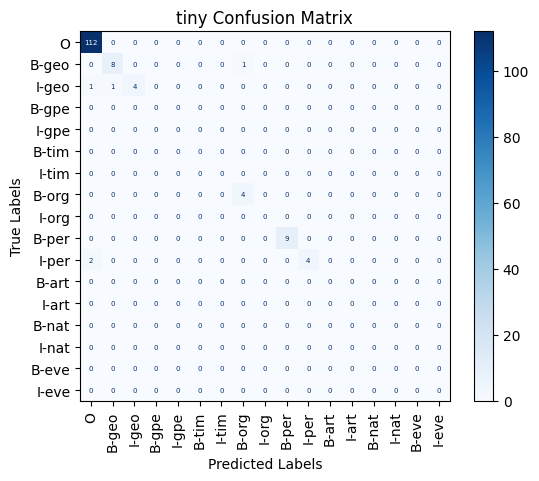

In [ ]:
print_scores(tiny, preds, "tiny")

### Real metrics on Train and Test

In [ ]:
train_no_preds = predict_big(model, train_dataset, train_wordids)
test_no_preds = predict_big(model, test_dataset, test_wordids)

In [ ]:
def reconstruct(df, predicted_labels_batch, wordids):
    real = df.groupby(by="sentence_id")["tags"].apply(list).reset_index()
    # Reconstruct the correct labels with the original words based on word_ids
    preds = []
    for j in range(len(wordids)):
        preds_j = []
        for i in range(len(real.loc[j]['tags'])):
            try:
                k = wordids[j].index(i) # find first occurrence of number in the preds
                preds_j.append(predicted_labels_batch[j][k])
            except ValueError:
                preds_j.append('O')
        preds.append(preds_j)
    return preds

In [ ]:
train_preds = reconstruct(train, train_no_preds, train_wordids)
test_preds = reconstruct(test, test_no_preds, test_wordids)

----- Train real metrics -----
Accuracy: 0.9911
Accuracy no O: 0.9538
F1 Score: 0.9911


<Figure size 1200x1000 with 0 Axes>

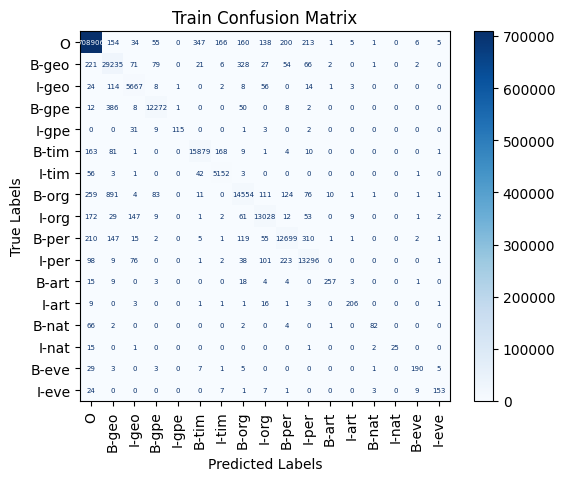

In [ ]:
print("----- Train real metrics -----")
print_scores(train, train_preds, "Train")

----- Test real metrics -----
Accuracy: 0.9471
Accuracy no O: 0.6824
F1 Score: 0.9457


<Figure size 1200x1000 with 0 Axes>

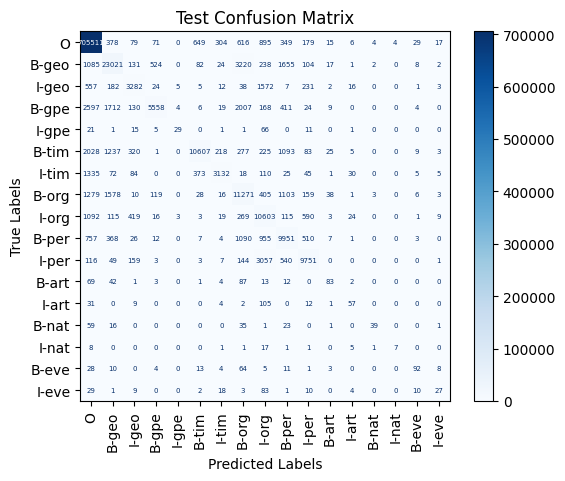

In [ ]:
print("----- Test real metrics -----")
print_scores(test, test_preds, "Test")